In [1]:
%pip install ccxt


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta

binance = ccxt.binance()

def obtener_datos(symbol='BTC/USDT', timeframe='1m', dias=10):
    # Calcular las fechas de inicio y fin
    fecha_fin = datetime.utcnow()  # Fecha y hora actuales en UTC
    fecha_inicio = fecha_fin - timedelta(days=dias - 1)  # Restar 'dias - 1' días desde la fecha actual

    # Convertir fechas a timestamp en milisegundos
    timestamp_inicio = int(fecha_inicio.timestamp() * 1000)
    timestamp_fin = int(fecha_fin.timestamp() * 1000)

    # Obtener datos en lotes hasta cubrir el rango de fechas
    velas = binance.fetch_ohlcv(symbol, timeframe=timeframe, since=timestamp_inicio, limit=None)

    # Crear un DataFrame de pandas
    df = pd.DataFrame(velas, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    return df

# Obtener datos de BTC/USDT para los últimos 10 días
datos = obtener_datos(symbol='BTC/USDT', dias=10)
print(datos.head())  # Mostrar los primeros registros para verificar



C:\Users\Emiliano\AppData\Local\Temp\ipykernel_12464\3723284982.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  fecha_fin = datetime.utcnow()  # Fecha y hora actuales en UTC


            timestamp      open      high       low     close   volume
0 2024-07-21 05:21:00  67080.00  67088.00  67074.87  67074.88  3.53728
1 2024-07-21 05:22:00  67074.88  67074.88  67067.34  67067.34  3.09745
2 2024-07-21 05:23:00  67067.34  67070.00  67035.45  67070.00  8.11957
3 2024-07-21 05:24:00  67070.00  67070.00  67064.00  67064.00  1.64822
4 2024-07-21 05:25:00  67064.00  67064.01  67015.02  67015.03  8.06829


In [3]:
print(datos)

              timestamp      open      high       low     close    volume
0   2024-07-21 05:21:00  67080.00  67088.00  67074.87  67074.88   3.53728
1   2024-07-21 05:22:00  67074.88  67074.88  67067.34  67067.34   3.09745
2   2024-07-21 05:23:00  67067.34  67070.00  67035.45  67070.00   8.11957
3   2024-07-21 05:24:00  67070.00  67070.00  67064.00  67064.00   1.64822
4   2024-07-21 05:25:00  67064.00  67064.01  67015.02  67015.03   8.06829
..                  ...       ...       ...       ...       ...       ...
495 2024-07-21 13:36:00  66727.99  66758.00  66714.01  66714.02  11.25686
496 2024-07-21 13:37:00  66714.02  66726.00  66702.00  66702.00   9.58450
497 2024-07-21 13:38:00  66702.01  66702.01  66667.68  66667.69  18.01173
498 2024-07-21 13:39:00  66667.69  66667.69  66616.00  66629.19  42.56359
499 2024-07-21 13:40:00  66629.20  66666.00  66629.19  66666.00  14.58719

[500 rows x 6 columns]


In [4]:
def calcular_emas(df):
    df['ema7'] = df['close'].ewm(span=7, adjust=False).mean()
    df['ema99'] = df['close'].ewm(span=99, adjust=False).mean()
    return df

datos = calcular_emas(datos)


In [5]:
print(datos)

              timestamp      open      high       low     close    volume  \
0   2024-07-21 05:21:00  67080.00  67088.00  67074.87  67074.88   3.53728   
1   2024-07-21 05:22:00  67074.88  67074.88  67067.34  67067.34   3.09745   
2   2024-07-21 05:23:00  67067.34  67070.00  67035.45  67070.00   8.11957   
3   2024-07-21 05:24:00  67070.00  67070.00  67064.00  67064.00   1.64822   
4   2024-07-21 05:25:00  67064.00  67064.01  67015.02  67015.03   8.06829   
..                  ...       ...       ...       ...       ...       ...   
495 2024-07-21 13:36:00  66727.99  66758.00  66714.01  66714.02  11.25686   
496 2024-07-21 13:37:00  66714.02  66726.00  66702.00  66702.00   9.58450   
497 2024-07-21 13:38:00  66702.01  66702.01  66667.68  66667.69  18.01173   
498 2024-07-21 13:39:00  66667.69  66667.69  66616.00  66629.19  42.56359   
499 2024-07-21 13:40:00  66629.20  66666.00  66629.19  66666.00  14.58719   

             ema7         ema99  
0    67074.880000  67074.880000  
1    67

In [6]:
import pandas as pd

def ejecutar_backtesting(df):
    capital_inicial = 1000
    capital = capital_inicial
    posicion_abierta = False
    cantidad_btc = 0
    historial_operaciones = []

    # Iterar sobre los datos
    for i in range(1, len(df)):
        # Identificar cuando la EMA(7) es igual a la EMA(99) y esperar al siguiente cambio
        if df['ema7'][i] == df['ema99'][i]:
            continue
        
        # Cuando la EMA(7) es mayor a la EMA(99), comprar si no hay posición abierta
        if df['ema7'][i] > df['ema99'][i] and not posicion_abierta:
            cantidad_btc = capital / df['close'][i]
            capital = 0
            posicion_abierta = True
            precio_compra = df['close'][i]
            historial_operaciones.append({'accion': 'Compra', 'timestamp': df['timestamp'][i], 'precio': precio_compra})
            print(f"Comprar en {df['timestamp'][i]} a {precio_compra:.2f}")
        
        # Cuando la EMA(99) es mayor a la EMA(7), vender si hay posición abierta
        elif df['ema99'][i] > df['ema7'][i] and posicion_abierta:
            capital = cantidad_btc * df['close'][i]
            cantidad_btc = 0
            posicion_abierta = False
            precio_venta = df['close'][i]
            ganancia = capital - capital_inicial
            historial_operaciones.append({'accion': 'Venta', 'timestamp': df['timestamp'][i], 'precio': precio_venta, 'ganancia': ganancia})
            print(f"Vender en {df['timestamp'][i]} a {precio_venta:.2f}, Ganancia/Perdida: {ganancia:.2f}")

    # Vender la posición abierta al final del período si aún está abierta
    if posicion_abierta:
        capital = cantidad_btc * df['close'].iloc[-1]
        ganancia = capital - capital_inicial
        historial_operaciones.append({'accion': 'Venta', 'timestamp': df['timestamp'].iloc[-1], 'precio': df['close'].iloc[-1], 'ganancia': ganancia})
        print(f"Vender en {df['timestamp'].iloc[-1]} a {df['close'].iloc[-1]:.2f}, Ganancia/Perdida: {ganancia:.2f}")

    # Calcular el rendimiento final
    rendimiento = ganancia
    print(f"Rendimiento final: {rendimiento:.2f}%")

    # Retornar historial de operaciones como DataFrame
    historial_operaciones_df = pd.DataFrame(historial_operaciones)
    return historial_operaciones_df

# Ejemplo de cómo usar la función ejecutar_backtesting con datos de un DataFrame df que tiene 'ema7', 'ema99', 'close' y 'timestamp'
# Asegúrate de tener los datos preparados antes de llamar a esta función

historial_operaciones_df = ejecutar_backtesting(datos)



Comprar en 2024-07-21 05:35:00 a 67092.00
Vender en 2024-07-21 05:43:00 a 67067.02, Ganancia/Perdida: -0.37
Comprar en 2024-07-21 05:46:00 a 67083.99
Vender en 2024-07-21 05:49:00 a 67060.00, Ganancia/Perdida: -0.73
Comprar en 2024-07-21 06:02:00 a 67090.01
Vender en 2024-07-21 06:03:00 a 67060.01, Ganancia/Perdida: -1.18
Comprar en 2024-07-21 08:06:00 a 66812.01
Vender en 2024-07-21 08:33:00 a 66756.00, Ganancia/Perdida: -2.01
Comprar en 2024-07-21 08:40:00 a 66790.00
Vender en 2024-07-21 09:01:00 a 66776.00, Ganancia/Perdida: -2.22
Comprar en 2024-07-21 09:02:00 a 66829.00
Vender en 2024-07-21 10:31:00 a 66900.00, Ganancia/Perdida: -1.16
Comprar en 2024-07-21 11:58:00 a 66869.06
Vender en 2024-07-21 12:42:00 a 66856.01, Ganancia/Perdida: -1.36
Comprar en 2024-07-21 12:58:00 a 66936.32
Vender en 2024-07-21 13:24:00 a 66882.02, Ganancia/Perdida: -2.17
Rendimiento final: -2.17%


In [7]:
print(historial_operaciones_df)
historial_operaciones_df.to_csv('ruta_csv', index=False)

    accion           timestamp    precio  ganancia
0   Compra 2024-07-21 05:35:00  67092.00       NaN
1    Venta 2024-07-21 05:43:00  67067.02 -0.372325
2   Compra 2024-07-21 05:46:00  67083.99       NaN
3    Venta 2024-07-21 05:49:00  67060.00 -0.729803
4   Compra 2024-07-21 06:02:00  67090.01       NaN
5    Venta 2024-07-21 06:03:00  67060.01 -1.176637
6   Compra 2024-07-21 08:06:00  66812.01       NaN
7    Venta 2024-07-21 08:33:00  66756.00 -2.013973
8   Compra 2024-07-21 08:40:00  66790.00       NaN
9    Venta 2024-07-21 09:01:00  66776.00 -2.223163
10  Compra 2024-07-21 09:02:00  66829.00       NaN
11   Venta 2024-07-21 10:31:00  66900.00 -1.163112
12  Compra 2024-07-21 11:58:00  66869.06       NaN
13   Venta 2024-07-21 12:42:00  66856.01 -1.358042
14  Compra 2024-07-21 12:58:00  66936.32       NaN
15   Venta 2024-07-21 13:24:00  66882.02 -2.168159


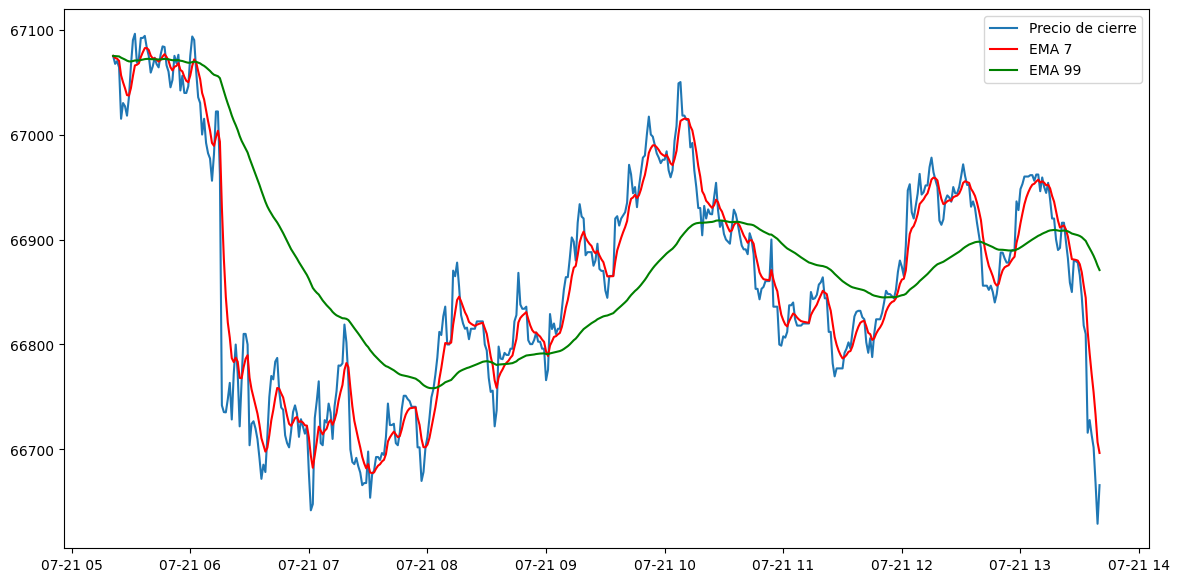

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(datos['timestamp'], datos['close'], label='Precio de cierre')
plt.plot(datos['timestamp'], datos['ema7'], label='EMA 7', color='r')
plt.plot(datos['timestamp'], datos['ema99'], label='EMA 99', color='g')
plt.legend()
plt.show()
